<a href="https://colab.research.google.com/github/OleksanderShevchenko/ShipVision/blob/main/ship_vision_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ShipVision Розробка моделі класифікації зображень суден по 10 класам

В даному журналі розглянемо як працюють згорткові нейронні мережі на прикладі класифікації зображень суден.

Будимо використовувати набір даних (dataset) що містить 10 класів суден.

Спочатку спробуємо просту архітектуру мережі, а потім застосуємо так зване навчання з передачею "знань" (transfer learning) або передавальне навчання.

In [1]:
# Перевіримо чи доступний нам графічний процессор
!nvidia-smi

Wed Nov  1 06:52:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Добре що так, бо тренування згорткових мереж зокрема (і нейронних мереж взагалі) відбувається значно швидьше, якщо нам доступний графічний процессор, або відеокарта по-простому.

## Завантаження набору даних (upload dataset)

In [2]:
!pip install kaggle

In [3]:
# створюємо директорію root/.kaggle/
!mkdir ~/.kaggle
# заватнажуємо туди файл kaggle.json

In [4]:
# Виділяємо дозвіл для цього файла
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# завантажуємо наш набір даних
!kaggle datasets download oleksandershevchenko/ship-classification-dataset

 93% 226M/243M [00:02<00:00, 171MB/s]
100% 243M/243M [00:02<00:00, 117MB/s]


In [6]:
import zipfile

# розпаковуємо архів
zip_ref = zipfile.ZipFile("ship-classification-dataset.zip")
zip_ref.extractall()
zip_ref.close()

## Станьте єдиним цілим з даними (Become one-with-data)
Розглянемо з чтого складаються наші данні і підготуємо набори для тренування нейронної мережі

In [7]:
# задаємо шлях до розпакованих даних
dataset_dir = "ships_dataset"
train_dir = "ships_dataset/train/"
test_dir = "ships_dataset/test/"
valid_dir = "ships_dataset/valid/"


In [29]:
# завантажуємо допоміжні функції
# helper_function.py - helping functions taken from https://github.com/mrdbourke/tensorflow-deep-learning/tree/main/extras (exapt cmodel creation)
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.layers.experimental import preprocessing
import zipfile

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# correct horizontal labels verticallt
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    plt.xlabel("Predicted label", fontsize=text_size+2)
    plt.ylabel("True label", fontsize=text_size+2)
    plt.title("Confusion Matrix", fontsize=text_size+5)
    ax.set( xticks=np.arange(n_classes), # create enough axis slots for each class
            yticks=np.arange(n_classes),
            xticklabels=labels, # axes will labeled with class names (if they exist) or ints
            yticklabels=labels,
            )


    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Change - plot x labels vertically #
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);


def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

    Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();


# create a function to compare training history
def compare_history(original_history, new_history, initial_epochs=10):
    """
    Compare history of TensorFlow training
    """
    #original history data
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    #new history data
    new_acc = new_history.history["accuracy"]
    new_loss = new_history.history["loss"]
    new_val_acc = new_history.history["val_accuracy"]
    new_val_loss = new_history.history["val_loss"]

    total_acc = acc + new_acc
    total_loss = loss + new_loss
    total_val_acc = val_acc + new_val_acc
    total_val_loss = val_loss + new_val_loss

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training accuracy")
    plt.plot(total_val_acc, label="Validation accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.title("Training and Validation Accuracy")
    plt.legend(loc="lower right")
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training loss")
    plt.plot(total_val_loss, label="Validation loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
def unzip_data(filename):
    """
    Unzips filename into the current working directory.

    Args:
    filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.

    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results


# Extend previous function with augmentation
def create_model(input_shape: tuple,
                 learning_rate=0.001,  # default Adam lr
                 output_classes_num = 101,
                 add_rescale: bool=False,
                 add_augmentation: bool=True,
                 is_mix_precision: bool=True,
                 is_label_one_hot_encoded: bool=True) -> tf.keras.Model:
    # 1. Create base model
    base_model = applications.EfficientNetB0(include_top=False)

    # 2. Freeze the base model
    base_model.trainable = False

    # 3. Create input layer
    inputs = layers.Input(shape=input_shape, name="input_layer")

    x = None

    # 4. Add rescale if required (for ResNet for example)
    if add_rescale:
        x = layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

    # 4.2 Add augmentation layer to the input
    if add_augmentation:
        data_augmentation = keras.Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomFlip("vertical"),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomZoom(0.2),
            preprocessing.RandomHeight(0.2),
            preprocessing.RandomWidth(0.2),
        ], name="data_augmentation")
        x = data_augmentation(inputs)

    if x is None:
        x = inputs

    # 5. Pass inputs to base model
    x = base_model(x)
    print(f"Shape after adding input to the base model: {x.shape}")

    # 6. Average pool the output of the base model
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    print(f"Shape after adding pooling layer to the base model: {x.shape}")

    # 7. create activation layer
    if is_mix_precision:
        x = layers.Dense(output_classes_num, name='dense_logits')(x)
        outputs = layers.Activation('softmax', dtype='float32', name='predictions_output_layer')(x)
    else:
        outputs = tf.keras.layers.Dense(output_classes_num, activation="softmax", name="predictions_output_layer")(x)

    # 8 conbine inputs and outputs into the model
    model_0 = tf.keras.Model(inputs, outputs)

    # 9. compile the model
    if is_label_one_hot_encoded:
        _loss = "categorical_crossentropy"
    else:
        _loss = "sparse_categorical_crossentropy"

    model_0.compile(loss=_loss,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics=["accuracy"])
    return model_0, base_model

In [9]:
# розглянемо що в середені наших папок
walk_through_dir(dataset_dir)

There are 3 directories and 0 images in 'ships_dataset'.
There are 10 directories and 0 images in 'ships_dataset/valid'.
There are 0 directories and 15 images in 'ships_dataset/valid/Sailboat'.
There are 0 directories and 23 images in 'ships_dataset/valid/Bulkers'.
There are 0 directories and 72 images in 'ships_dataset/valid/Submarine'.
There are 0 directories and 82 images in 'ships_dataset/valid/Container Ship'.
There are 0 directories and 11 images in 'ships_dataset/valid/Recreational'.
There are 0 directories and 179 images in 'ships_dataset/valid/Car Carrier'.
There are 0 directories and 84 images in 'ships_dataset/valid/DDG'.
There are 0 directories and 77 images in 'ships_dataset/valid/Tug'.
There are 0 directories and 74 images in 'ships_dataset/valid/Aircraft Carrier'.
There are 0 directories and 72 images in 'ships_dataset/valid/Cruise'.
There are 10 directories and 0 images in 'ships_dataset/test'.
There are 0 directories and 15 images in 'ships_dataset/test/Sailboat'.
Ther

In [10]:
# Створемо набори даних для тренування і верифікації у вигляді тензорів tensorflow
# зауважимо, що картинки у цих наборах розбиваються на группи (batches) по 32
# і приводяться до єдиної роздільної здатності картинки 224х224
import tensorflow as tf

IMG_SIZE=(224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=True)  # дані тренування обов'язково перемішуємо
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)  # дані тестування не перемішуємо
valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)  # дані верифікації не перемішуємо


Found 7629 files belonging to 10 classes.
Found 381 files belonging to 10 classes.
Found 689 files belonging to 10 classes.


In [11]:
# Отримуємо назви класів суден
class_names = train_data.class_names
class_names

['Aircraft Carrier',
 'Bulkers',
 'Car Carrier',
 'Container Ship',
 'Cruise',
 'DDG',
 'Recreational',
 'Sailboat',
 'Submarine',
 'Tug']

In [12]:
# розглянемо що являє собою один з тензорів у наборах для навчання
one_sample = train_data.take(1)
print(one_sample)
for image, label in one_sample:
  print(f"""
        Image shape {image[0].shape}
        Image datatype {image[0].dtype}
        Target class from Food101 (tensor form): {label[0]}
        Class name (str form): {class_names[label[0].numpy().argmax()]}
        """)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

        Image shape (224, 224, 3)
        Image datatype <dtype: 'float32'>
        Target class from Food101 (tensor form): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
        Class name (str form): Aircraft Carrier
        


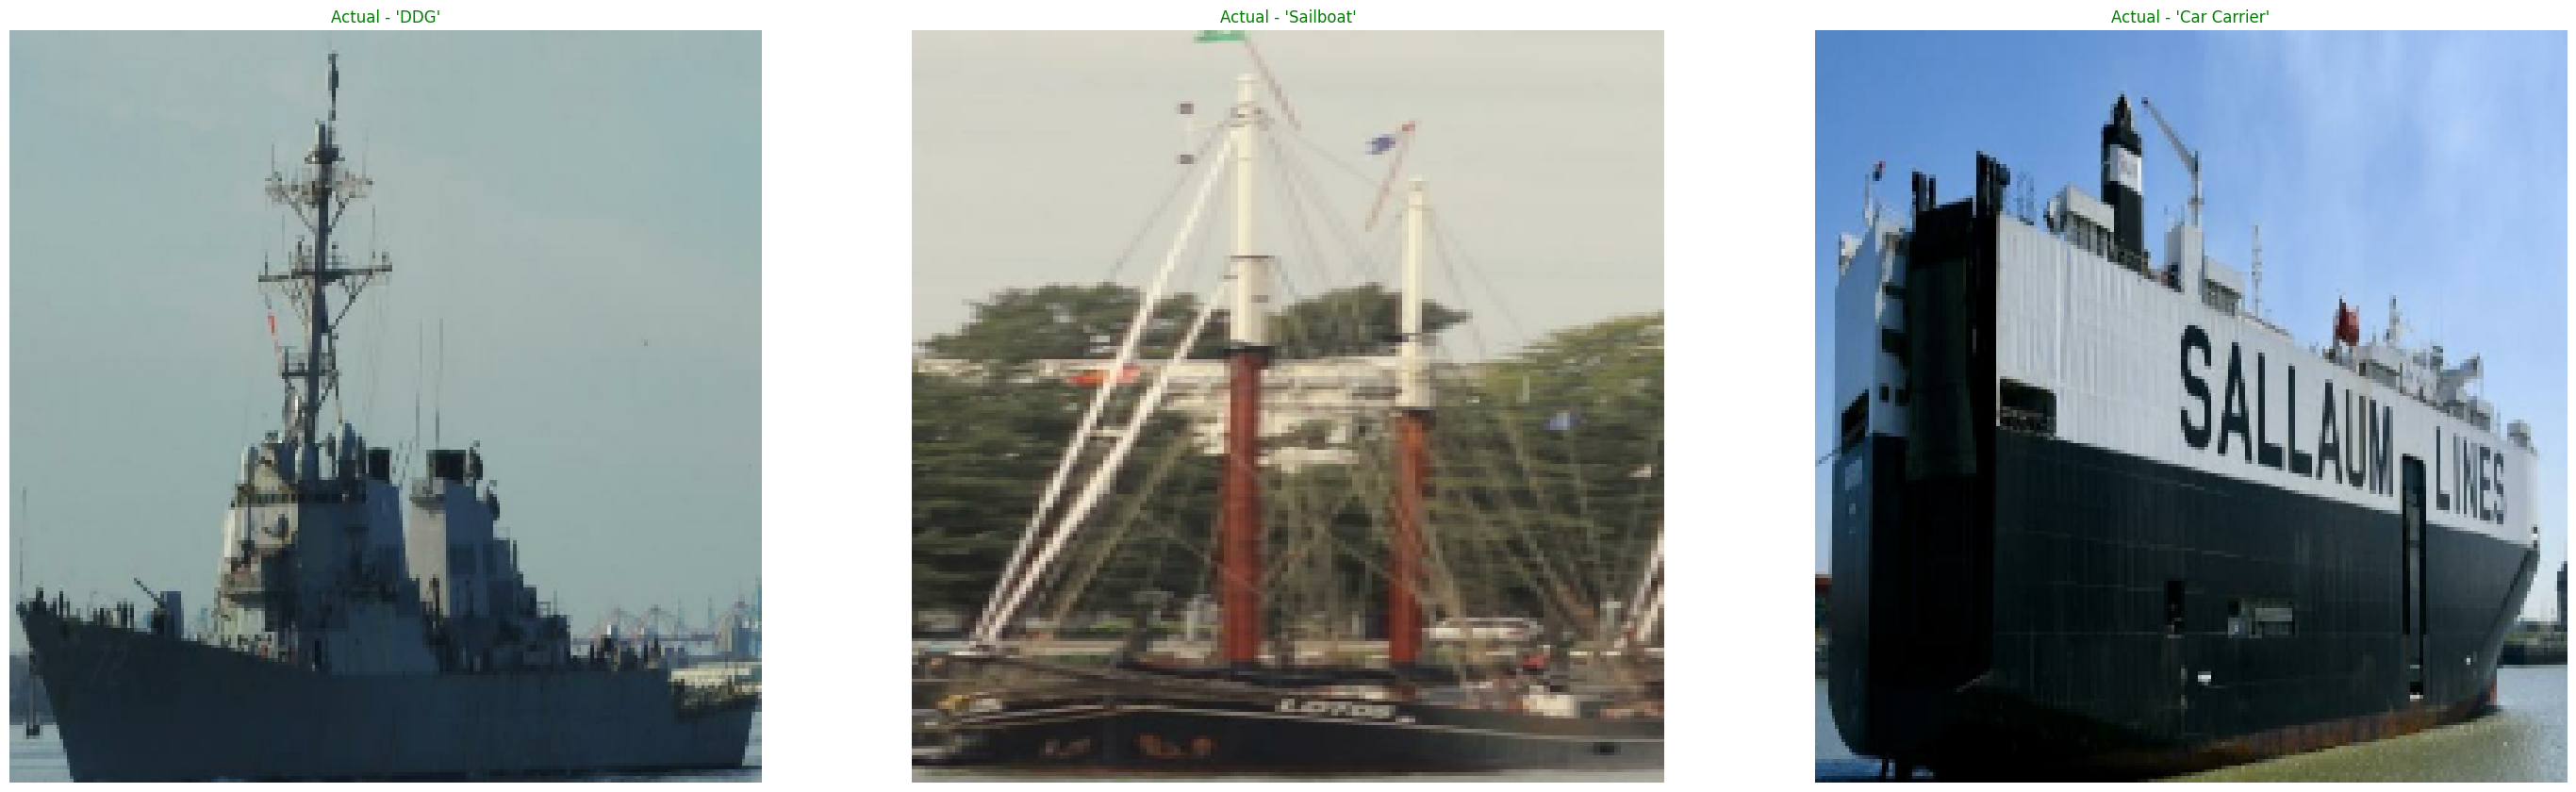

In [13]:
# Візуалізуємо 3 випадкові зображення
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(35, 35))
for i in range(3):
  class_name_ = random.choice(class_names)
  filename = random.choice(os.listdir(train_dir + "/" + class_name_))
  filepath = train_dir + class_name_ + "/" + filename

  # load the image and make prediction
  img = load_and_prep_image(filename=filepath, scale=False)

  # Plot the image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  title_color = "g"
  plt.title(f"Actual - '{class_name_}'", c=title_color)
  plt.axis(False)

## Створення моделі (від простого до складного)
Створемо просту модель Tiny VGG i випробуємо її на даній задачі класифікації

In [15]:
# Make the creation of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy


# Create Tiny VGG model
num_classes = 10
num_filters = 10
model_0 = Sequential([
    Conv2D(filters=num_filters, kernel_size=3,
           activation="relu", input_shape=(224, 224, 3)),
    Conv2D(num_filters, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(num_filters, 3, activation="relu"),
    Conv2D(num_filters, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(num_classes, activation="softmax")])

# Compile model
model_0.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/100
239/239 [==============================] - 10s 35ms/step - loss: 11.2705 - accuracy: 0.4818 - val_loss: 1.1731 - val_accuracy: 0.6194
Epoch 2/100
239/239 [==============================] - 8s 31ms/step - loss: 0.5428 - accuracy: 0.8355 - val_loss: 1.2924 - val_accuracy: 0.6325
Epoch 3/100
239/239 [==============================] - 8s 31ms/step - loss: 0.1797 - accuracy: 0.9501 - val_loss: 1.4800 - val_accuracy: 0.6667
Epoch 4/100
239/239 [==============================] - 8s 31ms/step - loss: 0.0647 - accuracy: 0.9855 - val_loss: 1.9518 - val_accuracy: 0.6667
Epoch 5/100
239/239 [==============================] - 8s 31ms/step - loss: 0.0434 - accuracy: 0.9915 - val_loss: 2.0685 - val_accuracy: 0.6325
Epoch 6/100
239/239 [==============================] - 8s 31ms/step - loss: 0.0401 - accuracy: 0.9904 - val_loss: 2.0450 - val_accuracy: 0.6509
Epoch 7/100
239/239 [==============================] - 8s 32ms/step - loss: 0.0412 - accuracy: 0.9900 - val_loss: 2.0160 - val_accurac

In [34]:
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

In [16]:
model_0.evaluate(valid_data)

22/22 [==============================] - 1s 21ms/step - loss: 9.8386 - accuracy: 0.7083


[9.838574409484863, 0.7082728743553162]

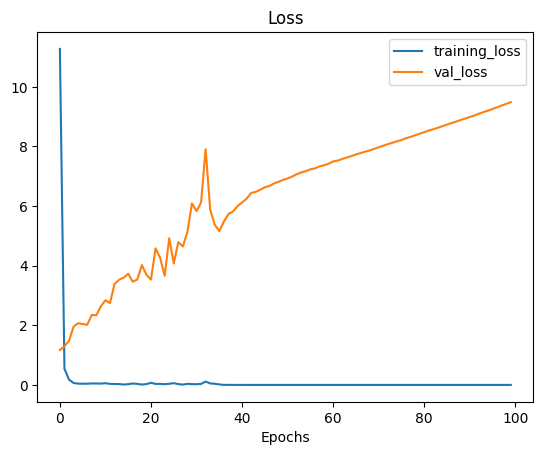

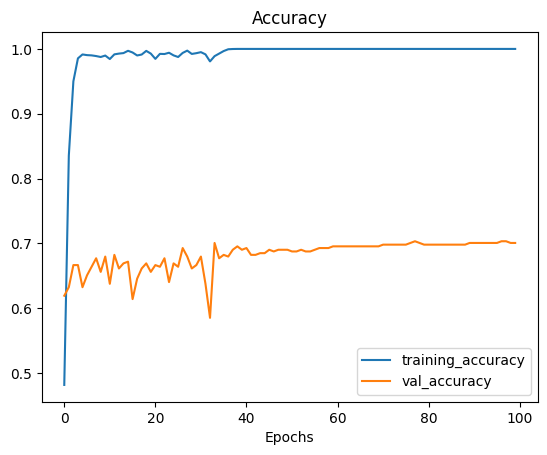

In [17]:
# Plot learning curves
plot_loss_curves(history_0)

Криві навчання засвідчують, що наша модуль перенавчена.

Побудуємо ще матрицю помилок (confusion matrix), щоб подивитися, які класи визначаються як інші і у якій пропорції

22/22 [==============================] - 0s 17ms/step


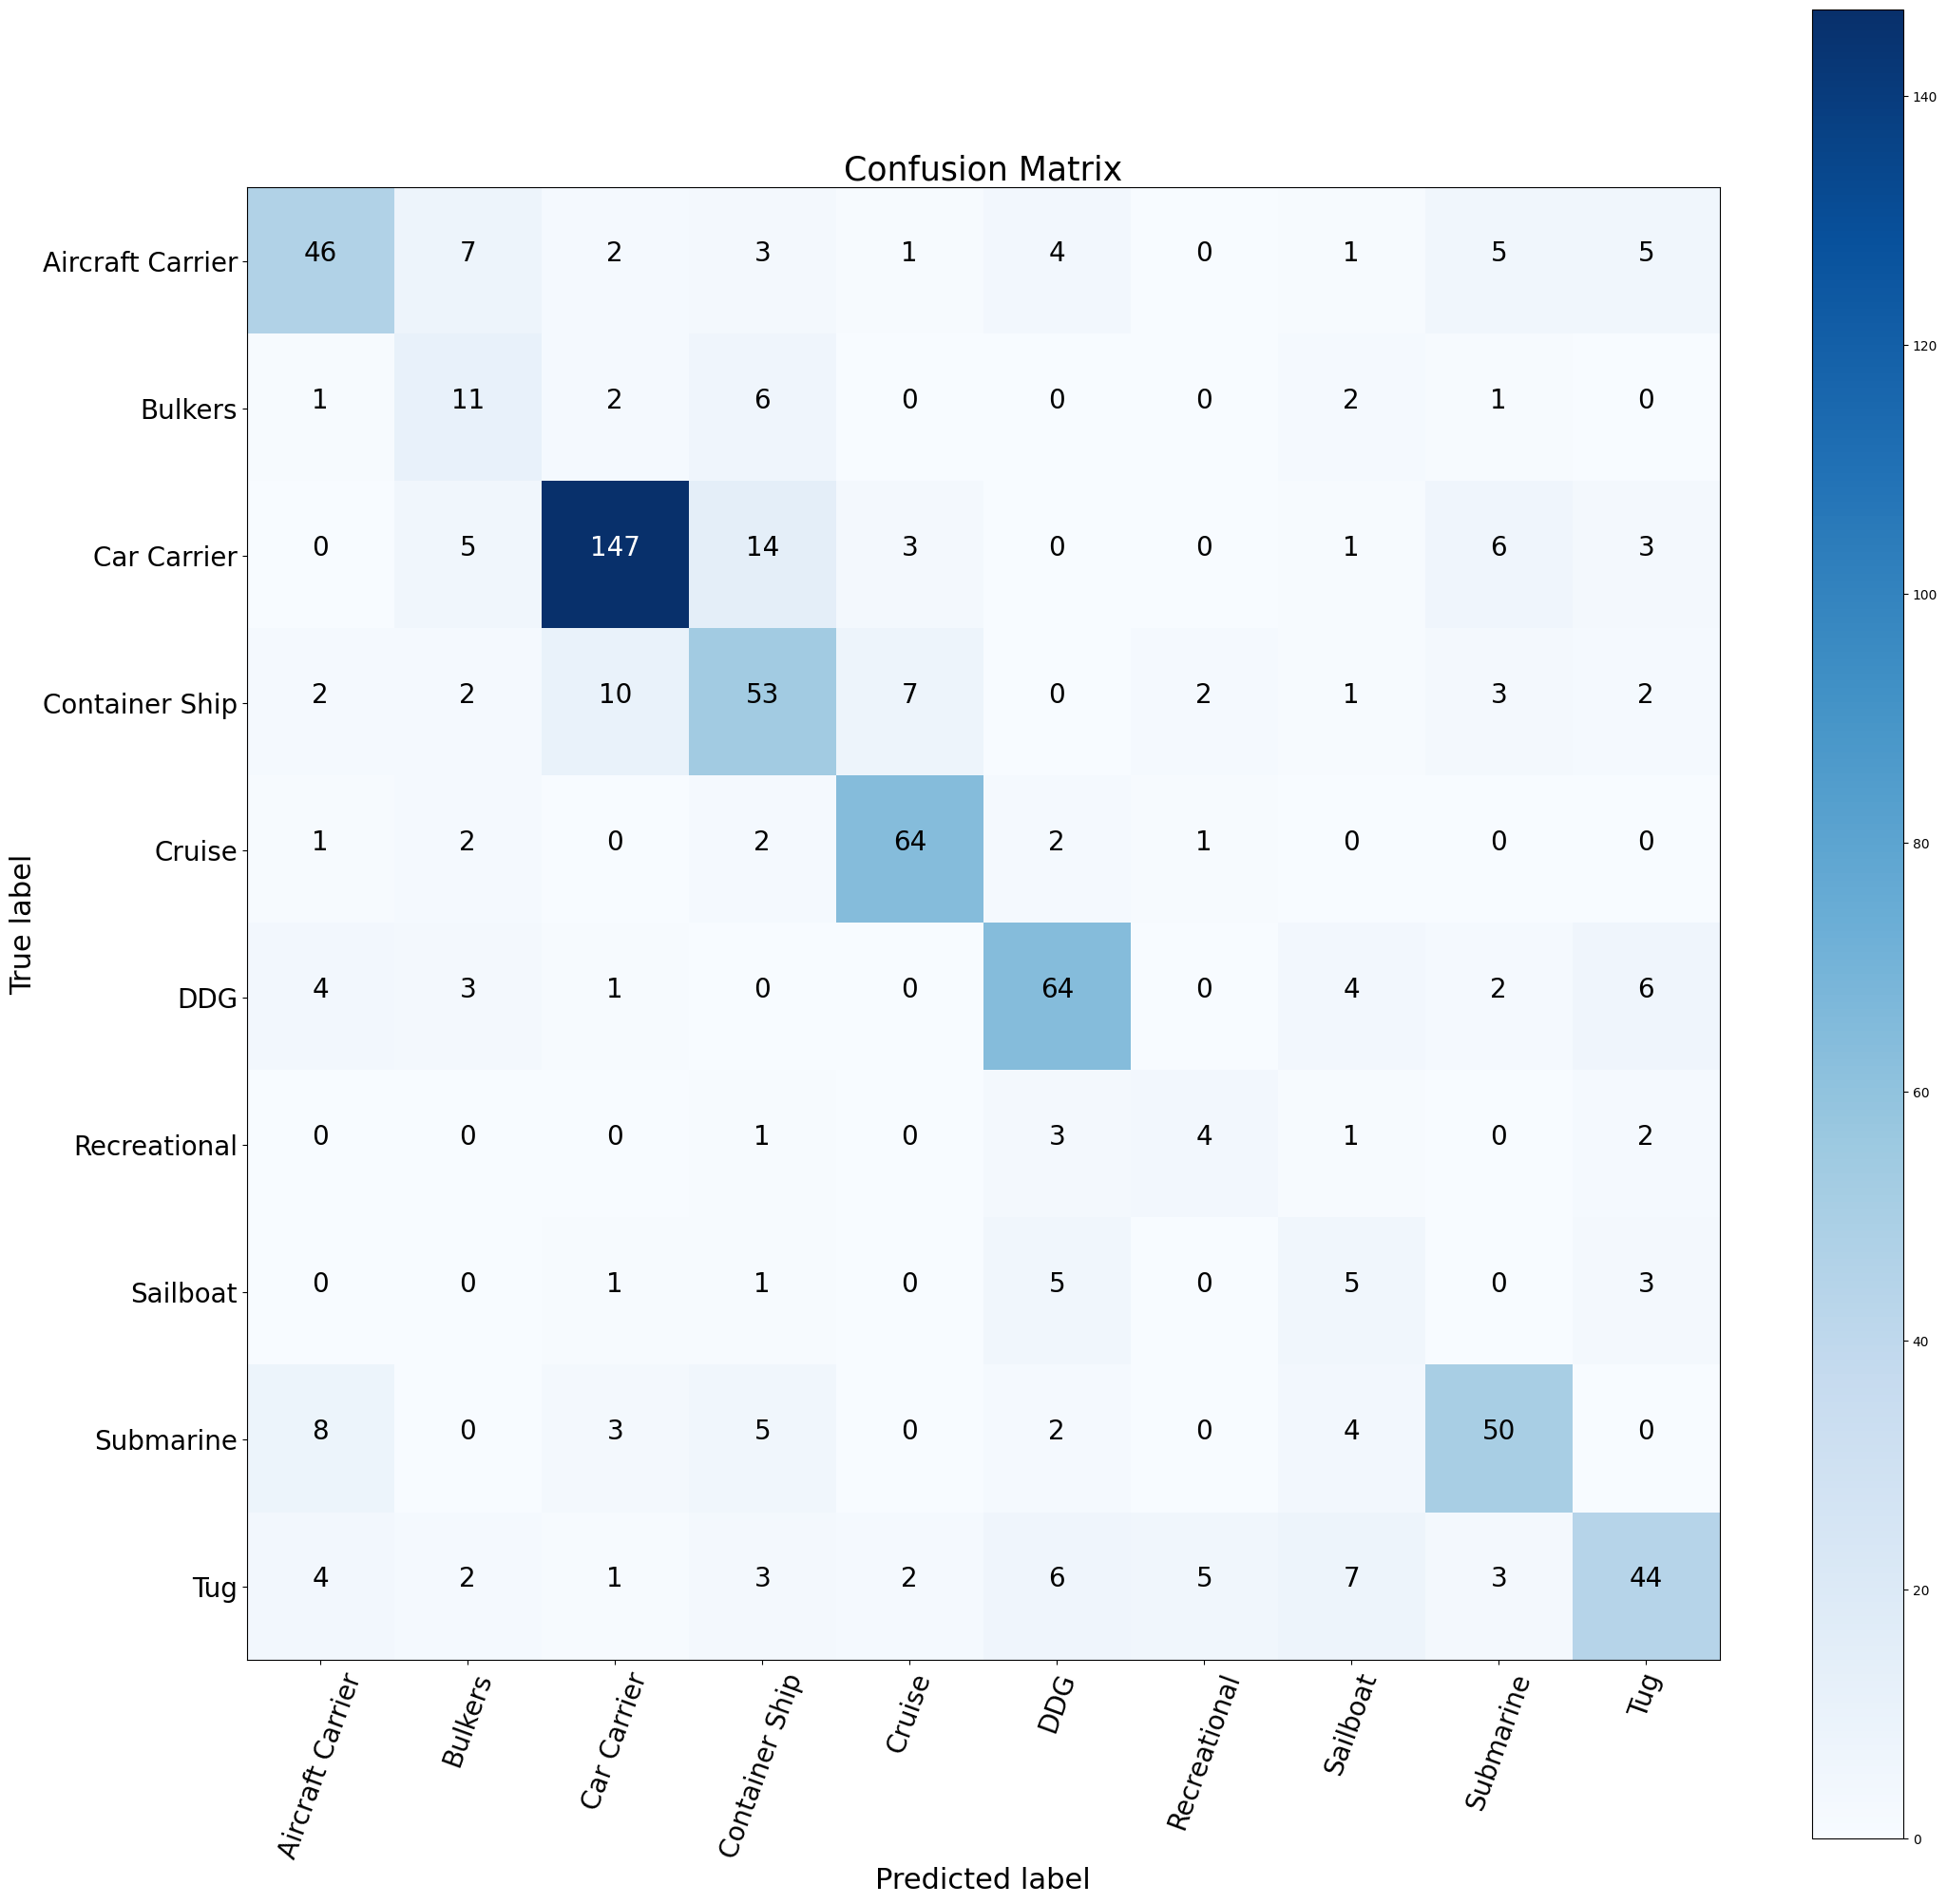

In [31]:
preds_probs = model_0.predict(valid_data, verbose=1)
pred_classes = preds_probs.argmax(axis=1)
# to get test data labels we need to unravel our test data
y_labels = []
for imagees, labels in valid_data.unbatch():
    y_labels.append(labels.numpy().argmax())  # curently our labbels looks like [0, 0, 0, ...,1, 0 ..]

make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, figsize=(25, 25), text_size=20, classes=class_names)

Матриця помилок також вказує як на недоліки нашого набору даних, так і на той факт, що деякі судна досить схожі.

**Висновок:** Дана проста модель майже одразу показує видатні результати на тренувальному наборі, але на тестовому наборі вона показує значно гірший результат. Тобто вона не узагальнюється на випадки на яких вона не навчалася.

У підсумку маємо 70% точності і яскравий приклад пере-навченої моделі.
Це означає, що наша модель нейроної мережі занадто проста для наших данних.

Слід ще зауважити також, що тестових і валідаційних даних замало у наборі даних, і сам набір зміщений (не рівна кількість даних для кожного класу).
Тому, за більшої кількості даних для тестування і валідації, а також при рівномірній кількості даних картина може бути гірше, і точність меньше 70%

## Модифікації моделі

### Збільшення кількості фільтрів
Спробуємо кілька модифікацій, щоб побачити як вони вплинуть на результат.

Спочатку змінемо кількість фільтрів з 10 до 32
Зменьшемо час тренування до 30 епох щоб не гаяти час, оскільки, коли модель виходить на "плато", далі тільки збільшуеться похибка валідації - ми побачимо цю тендкнцію на кривих навчання.

In [32]:
# Make the creation of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy


# Create Tiny VGG model
num_classes = 10
num_filters = 32
model_1 = Sequential([
    Conv2D(filters=num_filters, kernel_size=3,
           activation="relu", input_shape=(224, 224, 3)),
    Conv2D(num_filters, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(num_filters, 3, activation="relu"),
    Conv2D(num_filters, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(num_classes, activation="softmax")])

# Compile model
model_1.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=30,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/30
239/239 [==============================] - 23s 81ms/step - loss: 12.1026 - accuracy: 0.5606 - val_loss: 1.1166 - val_accuracy: 0.6745
Epoch 2/30
239/239 [==============================] - 18s 74ms/step - loss: 0.3787 - accuracy: 0.8837 - val_loss: 1.0963 - val_accuracy: 0.7139
Epoch 3/30
239/239 [==============================] - 18s 76ms/step - loss: 0.1382 - accuracy: 0.9621 - val_loss: 1.6012 - val_accuracy: 0.7087
Epoch 4/30
239/239 [==============================] - 19s 78ms/step - loss: 0.1061 - accuracy: 0.9746 - val_loss: 1.7021 - val_accuracy: 0.7323
Epoch 5/30
239/239 [==============================] - 18s 77ms/step - loss: 0.0744 - accuracy: 0.9796 - val_loss: 2.0397 - val_accuracy: 0.7060
Epoch 6/30
239/239 [==============================] - 18s 76ms/step - loss: 0.1168 - accuracy: 0.9726 - val_loss: 2.1093 - val_accuracy: 0.7034
Epoch 7/30
239/239 [==============================] - 18s 76ms/step - loss: 0.0991 - accuracy: 0.9733 - val_loss: 2.1749 - val_accuracy

In [33]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 32)      9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                 

In [36]:
model_1.evaluate(valid_data), model_0.evaluate(valid_data)

22/22 [==============================] - 0s 15ms/step - loss: 9.8386 - accuracy: 0.7083


([4.2515764236450195, 0.748911440372467],
 [9.838574409484863, 0.7082728743553162])

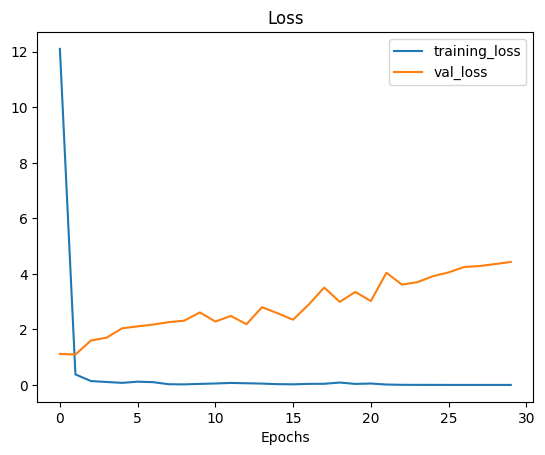

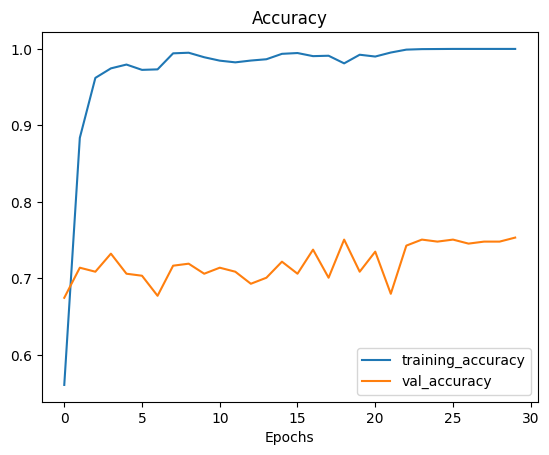

In [37]:
# Plot learning curves
plot_loss_curves(history_1)

In [22]:
num_classes = len(class_names)
image_size = IMG_SIZE + (3,)

model_1, base_model_1 = create_model(input_shape=image_size,
                                    learning_rate=0.001,
                                    output_classes_num=num_classes,
                                    add_augmentation=False,
                                    add_rescale=False,
                                    is_mix_precision=False,
                                    is_label_one_hot_encoded=True)
model_1.summary()

16705208/16705208 [==============================] - 2s 0us/step
Shape after adding input to the base model: (None, 7, 7, 1280)
Shape after adding pooling layer to the base model: (None, 1280)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 predictions_output_layer (  (None, 10)                12810     


In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tb_callback = create_tensorboard_callback("tensor_board", "ship_vision")
earlystop_callback = EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)
checkpoint_path = "model_checkpoint/cp.ckpt"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      monitor="val_accuracy",
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

Saving TensorBoard log files to: tensor_board/ship_vision/20231031-164713


In [26]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[tb_callback, earlystop_callback, checkpoint_callback])

Epoch 1/5
239/239 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8761
Epoch 1: val_accuracy improved from -inf to 0.94488, saving model to model_checkpoint/cp.ckpt
239/239 [==============================] - 34s 83ms/step - loss: 0.5300 - accuracy: 0.8761 - val_loss: 0.2352 - val_accuracy: 0.9449
Epoch 2/5
238/239 [============================>.] - ETA: 0s - loss: 0.1629 - accuracy: 0.9684
Epoch 2: val_accuracy improved from 0.94488 to 0.95013, saving model to model_checkpoint/cp.ckpt
239/239 [==============================] - 17s 70ms/step - loss: 0.1628 - accuracy: 0.9684 - val_loss: 0.1686 - val_accuracy: 0.9501
Epoch 3/5
238/239 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9781
Epoch 3: val_accuracy did not improve from 0.95013
239/239 [==============================] - 17s 69ms/step - loss: 0.1115 - accuracy: 0.9781 - val_loss: 0.1489 - val_accuracy: 0.9501
Epoch 4/5
238/239 [============================>.] - ETA: 0s - loss: 0.085

In [ ]:
model_1.evaluate(valid_data)

22/22 [==============================] - 34s 2s/step - loss: 0.0910 - accuracy: 0.9768


[0.09095614403486252, 0.9767779111862183]

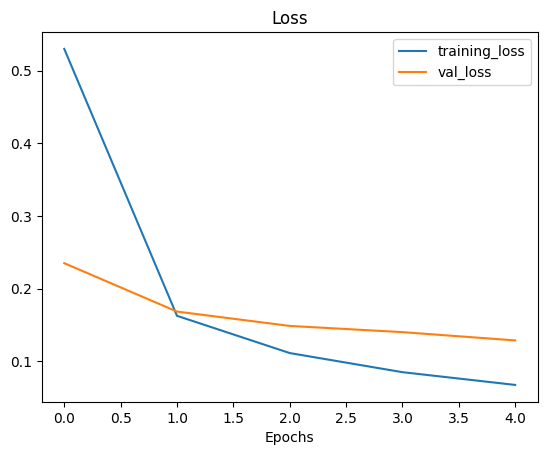

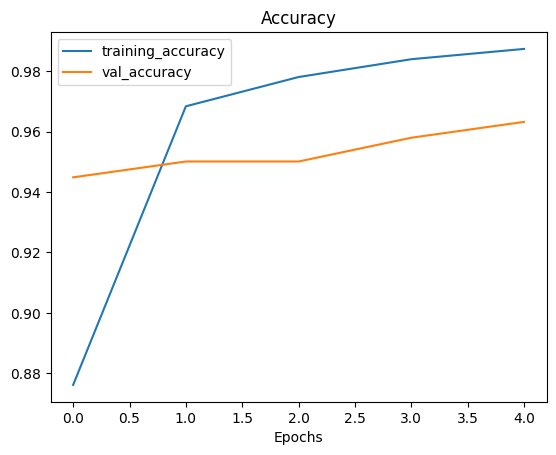

In [29]:
plot_loss_curves(history_1)